## 0. Install and Import Dependencies

In [3]:
# Install required libraries
!pip install gdown

# Import required libraries
import gdown

# Google Drive file URL
drive_url = "https://drive.google.com/uc?id=1HNjeK9KTzkC9z3j1T4jsfRNDlpOOGTLS"

# Download the file
output_file = "requirements.txt"
gdown.download(drive_url, output_file, quiet=False)

# Install packages from the requirements.txt file
!pip install -r requirements.txt

Downloading...
From: https://drive.google.com/uc?id=1HNjeK9KTzkC9z3j1T4jsfRNDlpOOGTLS
To: /content/requirements.txt
100%|██████████| 93.0/93.0 [00:00<00:00, 106kB/s]


In [4]:
# %cd /content/drive/MyDrive/Colab Notebooks
# !pip install -r requirements.txt

In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

#### Optimize performance with Tensorflow GPU usage.
(Requires presence of hardware GPU and Tensorflow version lesser than 2.11 for TensorflowGPU using CudaCNN. For certain scenarios and certain hardware, might cause issues in JIT compilation. - Google Collab recommended)

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Num GPUs Available:  0
[]


## 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 118MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    #loop through each frame and store it in array
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    #calculate the mean and standard deviation
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    #standardise or scale image features
    return tf.cast((frames - mean), tf.float32) / std
#LipNet uses DLib for face detection

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
#Character and Number conversions for alphabetic index using Keras CTC Loss function
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "
      f"(size = {char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [12]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    # Fix: Pass the result of tf.reshape to char_to_num
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    # Fix: Correct the function name to load_alignments
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [14]:
#Test Code
test_path = './data/s1/bbal6n.mpg'

In [15]:
#Test Code
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [16]:
#test Code
frames, alignments = load_data(tf.convert_to_tensor(test_path))

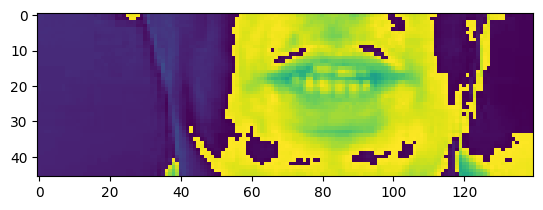

In [17]:
#Test Code
plt.imshow(frames[40])

In [18]:
#Test Code
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
#Wrap into a mappable function
from typing import Tuple
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result

## 2. Create Data Pipeline

In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg') #considers the dataset
data = data.shuffle(500, reshuffle_each_iteration=False) #take the first 500 and shuffle them up
# data.as_numpy_iterator().next()
data = data.map(mappable_function)
# data.as_numpy_iterator().next()
# # plt.imshow(frames[0])
# # alignments
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) #patching into group sizes of two and into a shape (40 tokens for each alignment)
data = data.prefetch(tf.data.AUTOTUNE) #prefetching to optimize our data pipeline
# Added for split
train = data.take(450)
test = data.skip(450)

In [21]:
len(test)

50

In [22]:
#Test Code
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames) #Test Code

2

In [24]:
#Test Code
sample = data.as_numpy_iterator()
val = sample.next(); val[0]

array([[[[[1.266676  ],
          [1.266676  ],
          [1.266676  ],
          ...,
          [9.276539  ],
          [0.07451035],
          [0.07451035]],

         [[1.266676  ],
          [1.266676  ],
          [1.266676  ],
          ...,
          [9.351049  ],
          [0.07451035],
          [0.        ]],

         [[1.3039311 ],
          [1.3039311 ],
          [1.3039311 ],
          ...,
          [0.07451035],
          [0.03725518],
          [0.03725518]],

         ...,

         [[0.8941242 ],
          [0.8941242 ],
          [0.8941242 ],
          ...,
          [9.351049  ],
          [9.351049  ],
          [9.351049  ]],

         [[0.8941242 ],
          [0.8941242 ],
          [0.8941242 ],
          ...,
          [9.351049  ],
          [9.313794  ],
          [9.313794  ]],

         [[0.8941242 ],
          [0.8941242 ],
          [0.8941242 ],
          ...,
          [9.351049  ],
          [9.313794  ],
          [9.313794  ]]],


        [[[1.3039

In [25]:
#Test code
imageio.mimsave('./animation.gif', val[0][0], fps=10)
#The output is no use. Check for a file saved as animation.gif in the directory.
#Open that to see how the sequence is being processed.

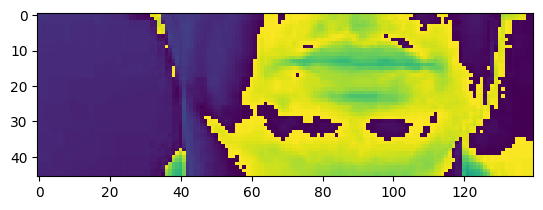

In [26]:
plt.imshow(val[0][0][74]) #Test Code
# 0:videos, 0:first video out of the batch, 74:return the last frame in the video

In [27]:
# Test Code
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green with e six now'>

## 3. Design the Deep Neural Network

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [29]:
data.as_numpy_iterator().next()[0][0].shape #fetching the input shape

(75, 46, 140, 1)

In [30]:
model = Sequential() #add layers one after another in a sequential order
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
#extract features from 3d data
# 128: no. of filters to learn complex feature patterns
# 3: kernel size - 3x3x3 cube
# shape of the input data that the model will expect (based on previous input) - (75 frames, 46 height, 140 width, 1 channel (grayscale))
# ensures that the output of the convolutional layer has the same spatial dimensions as the input
model.add(Activation('relu')) #introduces non-linearity into model
model.add(MaxPool3D((1,2,2))) #reduces the spatial dimensions of the data by taking the maximum value within a small window (here, 1x2x2)

# repeat the same thing with different no. of filters
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten())) #allow 75inputs into an LSTM - output 75units

# Block of a bidirectional LSTM layer followed by a dropout layer for regularization.
# These layers are crucial for processing sequential data, like the video frames.
# Repeated twice to create deeper network capable of learning more complex temporal patterns.
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

# Dense layer to handle special tokens
# 1 output per frame, 41: 1 hot encoded representation of our final output
# softmax activation: ability to use ArgMax value to be return the most likely value
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [32]:
5*17*75 #max_pooling3d_14 (MaxPooling3D)-(None, 75, 5, 17, 75) -> time_distributed_2 (TimeDistributed)-(None, 75, 6375)

6375

In [33]:
yhat = model.predict(val[0]) #prediction testing

1/1 [==============================] - 17s 17s/step


In [34]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]]) #string conversion of the prediction test

<tf.Tensor: shape=(), dtype=string, numpy=b'ptttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttddddd'>

In [35]:
model.input_shape

(None, 75, 46, 140, 1)

In [36]:
model.output_shape

(None, 75, 41)

### Setup Training Options and Train

In [37]:
# define a learning right scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1) #if epoch not below, we'll drop it using exponential function

In [38]:
# Taken from https://keras.io/examples/audio/ctc_asr/#model
# Speech Recognition Model using CTC (Connectionist Temporal Classification)
# Function relies on tf.keras.backend.ctc_batch_cost
# Calculates the loss between the model's predictions (y_pred) and the actual lip-reading targets (y_true).
# CTC - useful for sequences of varying lengths, like lip movements, to handle the alignment between input and output sequences automatically.
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length) #(75, 46, 140, 1)
    return loss

In [39]:
# Output a set of predictions
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        # decoded - Designed specifically to decode the applets of a CTC trained model

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [40]:
# Compiling model with Adam optimizer and CTC Loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [41]:
# Creates checkpoints of saved weights and loss monitoring of the model training
# Allow resuming training from previous points
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [42]:
# Drop learning rate each epoch to improve performance
schedule_callback = LearningRateScheduler(scheduler)

In [43]:
example_callback = ProduceExample(data) # For outputing predictions after each epoch

In [44]:
# This step requires a very high GPU usage power and a lot of time to fit the model.
# We will instead use a pre-trained checkpoint that has been prepared for 36hours.

# Uncomment the below line to run the epochs.
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

### 5. Make a Prediction

In [45]:
# Download the Pretrained Checkpoint file with 96 epochs
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 63.2MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [46]:
# Load the checkpoints into the model
model.load_weights('models/checkpoint')

In [59]:
test_data = test.as_numpy_iterator()

In [60]:
sample = test_data.next()

In [61]:
yhat = model.predict(sample[0]) # make predictions using the trained model

1/1 [==============================] - 13s 13s/step


In [62]:
# decodes the raw predictions made by yhat
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [63]:
# Shows the actual texts
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white with s four now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red in c five again'>]

In [64]:
# Shows the predicted texts using the model
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white with four now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red in c five again'>]

### Test on a Video

In [76]:
sample = load_data(tf.convert_to_tensor('./data/s1/brbg2n.mpg'))

In [77]:
# Actual Phrase
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red sp by g two now'>]

In [78]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 5s 5s/step


In [79]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [80]:
# Predicted Phrase
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red bp by two now'>]